# 3D case - Figures 9-10: 
Three-parameter 3D problem - Comparison with the FEM reference and plot of the solution for different parametric configurations

## Libraries import  

In [33]:

import sys  
import torch
import torch.nn as nn
from neurom.HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
import neurom.src.Pre_processing as pre
from neurom.src.PDE_Library import Strain, Stress,VonMises_plain_strain
from neurom.src.Training import Training_NeuROM_multi_level
import neurom.Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
from importlib import reload  
import tomllib
import numpy as np
import argparse

torch.manual_seed(0)

## Load the config file

In [34]:
Configuration_file = 'Configurations/config_3D_ROM_BiAngle_pretrained.toml'


with open(Configuration_file, mode="rb") as file:
    config = tomllib.load(file)

## Definition of the space domain and mechanical proprieties of the structure

The initial Material parameters, the geometry, mesh and the boundary conditions are set. 

In [35]:
# Load pretrained model dictionnary and get the corresponding mesh size to build an empty equivalent model

config["training"]["PreviousModel"] = "3D_ROM_BiAngle"

trained_dict = torch.load('Pretrained_models/'+config["training"]["PreviousModel"], weights_only=False)
config["interpolation"]["MaxElemSize2D"] = trained_dict["Space_modes.0.h_max"].item()


# Material parameters definition

Mat = pre.Material(             flag_lame = False,                                  # If True should input lmbda and mu instead of E and nu
                                coef1     = config["material"]["E"],                # Young Modulus
                                coef2     = config["material"]["nu"]                # Poisson's ratio
                )

# Create mesh object
MaxElemSize = pre.ElementSize(
                                dimension     = config["interpolation"]["dimension"],
                                L             = config["geometry"]["L"],
                                order         = config["interpolation"]["order"],
                                np            = config["interpolation"]["np"],
                                MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                            )
Excluded = []
Mesh_object = pre.Mesh( 
                                config["geometry"]["Name"],                         # Create the mesh object
                                MaxElemSize, 
                                config["interpolation"]["order"], 
                                config["interpolation"]["dimension"]
                        )

Mesh_object.AddBorders(config["Borders"]["Borders"])
Mesh_object.AddBCs(                                                                 # Include Boundary physical domains infos (BCs+volume)
                                config["geometry"]["Volume_element"],
                                Excluded,
                                config["DirichletDictionryList"]
                    )                   

Mesh_object.MeshGeo()                                                               # Mesh the .geo file if .msh does not exist
Mesh_object.ReadMesh()       
Mesh_object.ExportMeshVtk()

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  3.1.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 3D
 * Elements type:            4-node tetrahedron
 * Number of Dofs:           52137



## Parametric study definition

The hypercube describing the parametric domain used for the tensor decomposition is set-up here

In [36]:
match config["solver"]["N_ExtraCoordinates"]:
    case 3:
        ParameterHypercube = torch.tensor([ [   config["parameters"]["para_1_min"],
                                                config["parameters"]["para_1_max"],
                                                config["parameters"]["N_para_1"]],
                                            [   config["parameters"]["para_2_min"],
                                                config["parameters"]["para_2_max"],
                                                config["parameters"]["N_para_2"]],
                                            [   config["parameters"]["para_3_min"],
                                                config["parameters"]["para_3_max"],
                                                config["parameters"]["N_para_3"]]])
    case 2:
        ParameterHypercube = torch.tensor([ [   config["parameters"]["para_1_min"],
                                                config["parameters"]["para_1_max"],
                                                config["parameters"]["N_para_1"]],
                                            [   config["parameters"]["para_2_min"],
                                                config["parameters"]["para_2_max"],
                                                config["parameters"]["N_para_2"]]])
    case 1:
        ParameterHypercube = torch.tensor([[    config["parameters"]["para_1_min"],
                                                config["parameters"]["para_1_max"],
                                                config["parameters"]["N_para_1"]]])

## Initialisation of the surrogate model

In [37]:
ROM_model = NeuROM(                                                                 # Build the surrogate (reduced-order) model
                    Mesh_object, 
                    ParameterHypercube, 
                    config,
                    config["solver"]["n_modes_ini"],
                    config["solver"]["n_modes_max"]
                    )

## Initialiseing the model

In [38]:
# Initialise the model using the pre-loaded state dictionnary

ROM_model.load_state_dict(trained_dict)

<All keys matched successfully>

## Pyvista plots

Plot the solution and the error with regard to the Finite Element solution

In [39]:


E_vect = [0.038,0.0314,0.0462,0.0462]
theta_vect = [4.21,0,0.82,0]
phi_vect = [0,0,0,0.82]


In [40]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
import torch.nn as nn

pv.global_theme.font.family = 'times'                                           # Arial, courier or times
pv.global_theme.font.size = 40
pv.global_theme.font.title_size = 40
pv.global_theme.font.label_size = 40
pv.global_theme.font.fmt = '%.2e'

filename = 'Geometries/'+Mesh_object.name_mesh                                  # Load mesh (used for projecting the solution only) 
mesh = pv.read(filename)                                                        # Create pyvista mesh    
Nodes = np.stack(Mesh_object.Nodes)  
import matplotlib
matplotlib.rcParams["font.size"] = "25"


Plot_mesh               = config["postprocess"]["Plot_mesh"]
color_map               = config["postprocess"]["colormap"]

## First parameters set

E = 0.038, theta = 4.21, theta_deg = 241.21523175007655


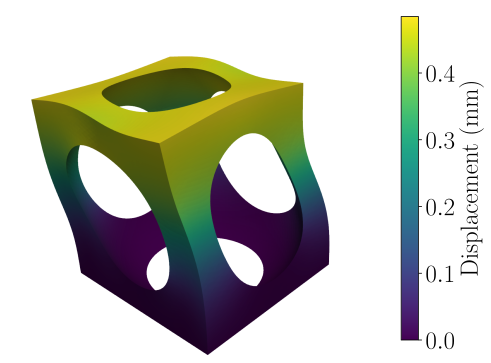

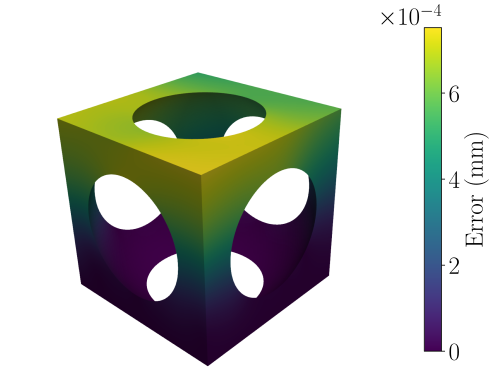

In [41]:
#Fig a)

name = 'BiAngle_a'

theta_i = theta_vect[0]
E_i = E_vect[0]
phi_i = phi_vect[0]

print(f'E = {E_i}, theta = {theta_i}, theta_deg = {theta_i*180/np.pi}')

num_displ_file = "GroundTruth/nodal_num_displacement_E="+str(E_i)+"_theta="+str(theta_i)+"_phi="+str(phi_i)+".npy"

num_displ = torch.tensor(np.load(num_displ_file))

theta = torch.tensor([theta_i],dtype=torch.float64)
theta = theta[:,None] 

phi = torch.tensor([phi_i],dtype=torch.float64)#DEBUG
phi = phi[:,None] 

E = torch.tensor([E_i],dtype=torch.float64)
E = E[:,None] 


Para_coord_list = nn.ParameterList((E,theta,phi))
ROM_model.eval()                                                        # Put model in evaluation mode
u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model
u = torch.stack([(u_sol[0,:,0,0,0]),(u_sol[1,:,0,0,0]),(u_sol[2,:,0,0,0])],dim=1)
u_ref  = torch.stack([(num_displ[:,0]),(num_displ[:,1]),(num_displ[:,2])],dim=1)
error_ref = torch.abs(u-u_ref)

mesh.point_data['U'] = u.data
mesh.point_data['U_norm'] = torch.norm(u, dim=1).data
mesh.point_data['Ux'] = u[:,0].data
mesh.point_data['Uy'] = u[:,1].data
mesh.point_data['Uz'] = u[:,2].data
mesh.point_data['error'] = error_ref.data
mesh.point_data['error_norm'] = torch.norm(error_ref, dim=1).data

## Result a)
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(mesh.warp_by_vector(vectors="U",factor=5,inplace=False), scalars='U_norm', show_edges=Plot_mesh, cmap=color_map, show_scalar_bar=False)

# plotter.view_xy()

plotter.camera_position =[(26.309406074377964, 21.00538551372031, 26.222044302615522),
 (4.9933824317258155, 5.175682697882241, 4.99824273226951),
 (-0.30492032647054207, 0.8843920301212331, -0.35337562389494537)]

plotter.camera.zoom(0.7)  # Zoom out by a factor of 1.5


import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.81, 0.25, 0.03, 0.5]) 
    
    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['U_norm'].min(), vmax=mesh.point_data['U_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps[color_map]

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Displacement (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight',pad_inches = 0)
    plt.show(fig)
    plt.close(fig)

## Error a)
plotter = pv.Plotter(off_screen=True)
# plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=5,inplace=False), scalars='error_norm', cmap=color_map, clim=[0, 0.05],show_scalar_bar=False)
plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=5,inplace=False), scalars='error_norm', show_edges=Plot_mesh, cmap=color_map,show_scalar_bar=False)

# plotter.view_xy()

plotter.camera_position =[(26.309406074377964, 21.00538551372031, 26.222044302615522),
 (4.9933824317258155, 5.175682697882241, 4.99824273226951),
 (-0.30492032647054207, 0.8843920301212331, -0.35337562389494537)]

plotter.camera.zoom(0.7)  # Zoom out by a factor of 1.5


image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_error_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5]) 


    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['error_norm'].min(), vmax=mesh.point_data['error_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps[color_map]

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Error (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight')
    plt.show(fig)
    plt.close(fig)

## Second parameters set

E = 0.0314, theta = 0, theta_deg = 0.0


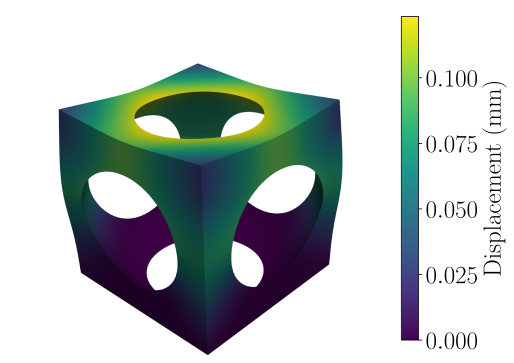

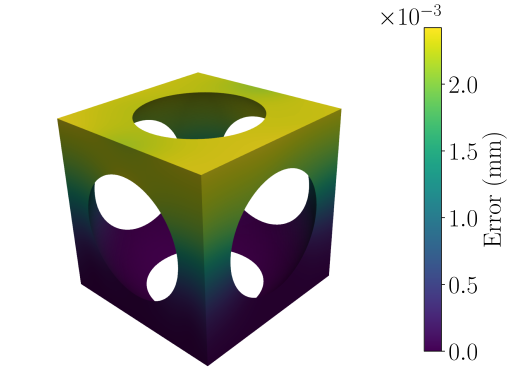

In [42]:
#Fig b)

name = 'BiAngle_b'

theta_i = theta_vect[1]
E_i = E_vect[1]
phi_i = phi_vect[1]

print(f'E = {E_i}, theta = {theta_i}, theta_deg = {theta_i*180/np.pi}')

num_displ_file = "GroundTruth/nodal_num_displacement_E="+str(E_i)+"_theta="+str(theta_i)+"_phi="+str(phi_i)+".npy"

num_displ = torch.tensor(np.load(num_displ_file))

theta = torch.tensor([theta_i],dtype=torch.float64)
theta = theta[:,None] 

phi = torch.tensor([phi_i],dtype=torch.float64)#DEBUG
phi = phi[:,None] 

E = torch.tensor([E_i],dtype=torch.float64)
E = E[:,None] 


Para_coord_list = nn.ParameterList((E,theta,phi))
ROM_model.eval()                                                        # Put model in evaluation mode
u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model
u = torch.stack([(u_sol[0,:,0,0,0]),(u_sol[1,:,0,0,0]),(u_sol[2,:,0,0,0])],dim=1)
u_ref  = torch.stack([(num_displ[:,0]),(num_displ[:,1]),(num_displ[:,2])],dim=1)
error_ref = torch.abs(u-u_ref)

mesh.point_data['U'] = u.data
mesh.point_data['U_norm'] = torch.norm(u, dim=1).data
mesh.point_data['Ux'] = u[:,0].data
mesh.point_data['Uy'] = u[:,1].data
mesh.point_data['Uz'] = u[:,2].data
mesh.point_data['error'] = error_ref.data
mesh.point_data['error_norm'] = torch.norm(error_ref, dim=1).data

## Result b)
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(mesh.warp_by_vector(vectors="U",factor=5,inplace=False), scalars='U_norm', show_edges=Plot_mesh, cmap=color_map, show_scalar_bar=False)

# plotter.view_xy()

plotter.camera_position =[(26.309406074377964, 21.00538551372031, 26.222044302615522),
 (4.9933824317258155, 5.175682697882241, 4.99824273226951),
 (-0.30492032647054207, 0.8843920301212331, -0.35337562389494537)]

plotter.camera.zoom(0.7)  # Zoom out by a factor of 1.5

import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.81, 0.25, 0.03, 0.5]) 
    
    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['U_norm'].min(), vmax=mesh.point_data['U_norm'].max())
    # cmap = cm.get_cmap('viridis')
    # cmap = matplotlib.colormaps[color_map]
    cmap = matplotlib.colormaps[color_map]

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Displacement (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight',pad_inches = 0)
    plt.show(fig)
    plt.close(fig)

## Error b)
plotter = pv.Plotter(off_screen=True)
# plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=5,inplace=False), scalars='error_norm', cmap=color_map, clim=[0, 0.05],show_scalar_bar=False)
plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=5,inplace=False), scalars='error_norm', show_edges=Plot_mesh, cmap=color_map,show_scalar_bar=False)

# plotter.view_xy()

plotter.camera_position =[(26.309406074377964, 21.00538551372031, 26.222044302615522),
 (4.9933824317258155, 5.175682697882241, 4.99824273226951),
 (-0.30492032647054207, 0.8843920301212331, -0.35337562389494537)]

plotter.camera.zoom(0.7)  # Zoom out by a factor of 1.5


import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_error_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5]) 


    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['error_norm'].min(), vmax=mesh.point_data['error_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps[color_map]

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Error (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight')
    plt.show(fig)
    plt.close(fig)

## Third parameters set

E = 0.0462, theta = 0.82, theta_deg = 46.9825392007275


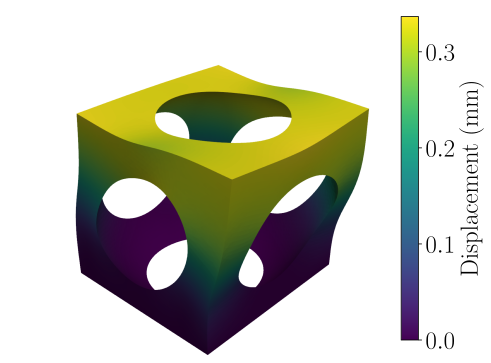

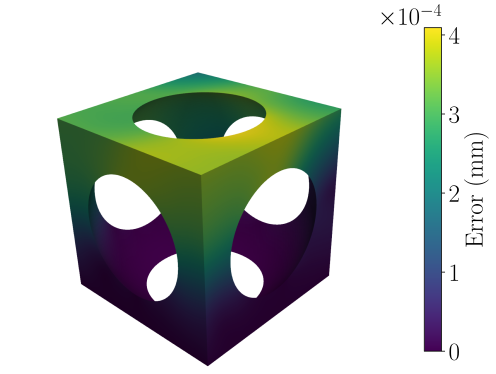

In [43]:
#Fig c)

name = 'BiAngle_c'

theta_i = theta_vect[2]
E_i = E_vect[2]
phi_i = phi_vect[2]

print(f'E = {E_i}, theta = {theta_i}, theta_deg = {theta_i*180/np.pi}')

num_displ_file = "GroundTruth/nodal_num_displacement_E="+str(E_i)+"_theta="+str(theta_i)+"_phi="+str(phi_i)+".npy"

num_displ = torch.tensor(np.load(num_displ_file))

theta = torch.tensor([theta_i],dtype=torch.float64)
theta = theta[:,None] 

phi = torch.tensor([phi_i],dtype=torch.float64)#DEBUG
phi = phi[:,None] 

E = torch.tensor([E_i],dtype=torch.float64)
E = E[:,None] 


Para_coord_list = nn.ParameterList((E,theta,phi))
ROM_model.eval()                                                        # Put model in evaluation mode
u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model
u = torch.stack([(u_sol[0,:,0,0,0]),(u_sol[1,:,0,0,0]),(u_sol[2,:,0,0,0])],dim=1)
u_ref  = torch.stack([(num_displ[:,0]),(num_displ[:,1]),(num_displ[:,2])],dim=1)
error_ref = torch.abs(u-u_ref)

mesh.point_data['U'] = u.data
mesh.point_data['U_norm'] = torch.norm(u, dim=1).data
mesh.point_data['Ux'] = u[:,0].data
mesh.point_data['Uy'] = u[:,1].data
mesh.point_data['Uz'] = u[:,2].data
mesh.point_data['error'] = error_ref.data
mesh.point_data['error_norm'] = torch.norm(error_ref, dim=1).data

## Result c)
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(mesh.warp_by_vector(vectors="U",factor=5,inplace=False), scalars='U_norm', show_edges=Plot_mesh, cmap=color_map, show_scalar_bar=False)

# plotter.view_xy()

plotter.camera_position =[(26.309406074377964, 21.00538551372031, 26.222044302615522),
 (4.9933824317258155, 5.175682697882241, 4.99824273226951),
 (-0.30492032647054207, 0.8843920301212331, -0.35337562389494537)]

plotter.camera.zoom(0.7)  # Zoom out by a factor of 1.5


import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.81, 0.25, 0.03, 0.5]) 
    
    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['U_norm'].min(), vmax=mesh.point_data['U_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps[color_map]

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Displacement (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight',pad_inches = 0)
    plt.show(fig)
    plt.close(fig)

## Error c)
plotter = pv.Plotter(off_screen=True)
# plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=5,inplace=False), scalars='error_norm', cmap=color_map, clim=[0, 0.05],show_scalar_bar=False)
plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=5,inplace=False), scalars='error_norm', show_edges=Plot_mesh, cmap=color_map,show_scalar_bar=False)

# plotter.view_xy()

plotter.camera_position =[(26.309406074377964, 21.00538551372031, 26.222044302615522),
 (4.9933824317258155, 5.175682697882241, 4.99824273226951),
 (-0.30492032647054207, 0.8843920301212331, -0.35337562389494537)]

plotter.camera.zoom(0.7)  # Zoom out by a factor of 1.5


import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_error_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5]) 


    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['error_norm'].min(), vmax=mesh.point_data['error_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps[color_map]

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Error (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight')
    plt.show(fig)
    plt.close(fig)

E = 0.0462, theta = 0, theta_deg = 0.0


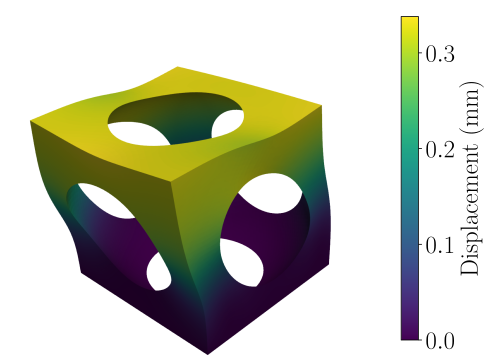

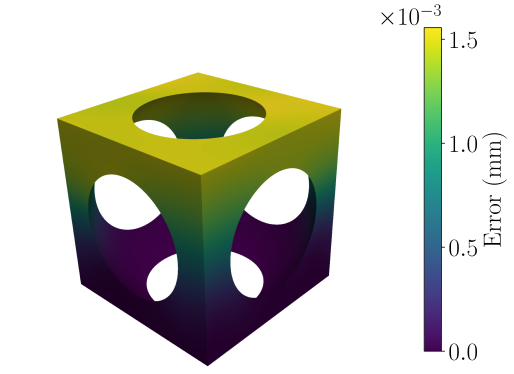

In [44]:
#Fig c)

name = 'BiAngle_d'

theta_i = theta_vect[3]
E_i = E_vect[3]
phi_i = phi_vect[3]

print(f'E = {E_i}, theta = {theta_i}, theta_deg = {theta_i*180/np.pi}')

num_displ_file = "GroundTruth/nodal_num_displacement_E="+str(E_i)+"_theta="+str(theta_i)+"_phi="+str(phi_i)+".npy"

num_displ = torch.tensor(np.load(num_displ_file))

theta = torch.tensor([theta_i],dtype=torch.float64)
theta = theta[:,None] 

phi = torch.tensor([phi_i],dtype=torch.float64)#DEBUG
phi = phi[:,None] 

E = torch.tensor([E_i],dtype=torch.float64)
E = E[:,None] 


Para_coord_list = nn.ParameterList((E,theta,phi))
ROM_model.eval()                                                        # Put model in evaluation mode
u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model
u = torch.stack([(u_sol[0,:,0,0,0]),(u_sol[1,:,0,0,0]),(u_sol[2,:,0,0,0])],dim=1)
u_ref  = torch.stack([(num_displ[:,0]),(num_displ[:,1]),(num_displ[:,2])],dim=1)
error_ref = torch.abs(u-u_ref)

mesh.point_data['U'] = u.data
mesh.point_data['U_norm'] = torch.norm(u, dim=1).data
mesh.point_data['Ux'] = u[:,0].data
mesh.point_data['Uy'] = u[:,1].data
mesh.point_data['Uz'] = u[:,2].data
mesh.point_data['error'] = error_ref.data
mesh.point_data['error_norm'] = torch.norm(error_ref, dim=1).data

## Result c)
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(mesh.warp_by_vector(vectors="U",factor=5,inplace=False), scalars='U_norm', show_edges=Plot_mesh, cmap=color_map, show_scalar_bar=False)

# plotter.view_xy()

plotter.camera_position =[(26.309406074377964, 21.00538551372031, 26.222044302615522),
 (4.9933824317258155, 5.175682697882241, 4.99824273226951),
 (-0.30492032647054207, 0.8843920301212331, -0.35337562389494537)]

plotter.camera.zoom(0.7)  # Zoom out by a factor of 1.5


import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.81, 0.25, 0.03, 0.5]) 
    
    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['U_norm'].min(), vmax=mesh.point_data['U_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps[color_map]

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Displacement (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight',pad_inches = 0)
    plt.show(fig)
    plt.close(fig)

## Error c)
plotter = pv.Plotter(off_screen=True)
# plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=5,inplace=False), scalars='error_norm', cmap=color_map, clim=[0, 0.05],show_scalar_bar=False)
plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=5,inplace=False), scalars='error_norm', show_edges=Plot_mesh, cmap=color_map,show_scalar_bar=False)

# plotter.view_xy()

plotter.camera_position =[(26.309406074377964, 21.00538551372031, 26.222044302615522),
 (4.9933824317258155, 5.175682697882241, 4.99824273226951),
 (-0.30492032647054207, 0.8843920301212331, -0.35337562389494537)]

plotter.camera.zoom(0.7)  # Zoom out by a factor of 1.5


import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_error_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5]) 


    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['error_norm'].min(), vmax=mesh.point_data['error_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps[color_map]

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Error (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight')
    plt.show(fig)
    plt.close(fig)